<a target="_blank" href="https://colab.research.google.com/github/giordamaug/HELP/blob/main/HELPpy/notebooks/prediction.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a target="_blank" href="https://www.kaggle.com/notebooks/welcome?src=https://github.com/giordamaug/HELP/blob/main/HELPpy/notebooks/prediction.ipynb">
  <img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Colab"/>
</a>

### 1. Install HELP from GitHub
Skip this cell if you already have installed HELP.

In [ ]:
!pip install git+https://github.com/giordamaug/HELP.git

### 2. Download the input files
For a chosen tissue (here `Kidney`), download from GitHub the label file (here `Kidney_HELP.csv`, computed as in Example 1) and the attribute files (here BIO `Kidney_BIO.csv`, CCcfs `Kidney_CCcfs_1.csv`, ..., `Kidney_CCcfs_5.csv`, and N2V `Kidney_EmbN2V_128.csv`).  

Skip this step if you already have these input files locally.

In [ ]:
tissue='Kidney'
!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/{tissue}_HELP.csv
!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/{tissue}_BIO.csv
for i in range(5):
  !wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/{tissue}_CCcfs_{i}.csv
!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/{tissue}_EmbN2V_128.csv

Observe that the CCcfs file has been subdivided into 5 separate files for storage limitations on GitHub. 

### 3. Load the input files and process the tissue attributes

+ The label file (`Kidney_HELP.csv`) can be loaded via `read_csv`; its three-class labels (`E`, `aE`, `sNE`) are converted to two-class labels (`E`, `NE`); 

+ The tissue gene attributes are loaded and assembled via `feature_assemble_df` using the downloaded datafiles BIO, CCcfs subdivided into 5 subfiles (`'nchunks': 5`) and embedding. We do not apply missing values fixing (`'fixna': False`), while we do apply data scaling (`'normalize': 'std'`) to the BIO and CCcfs attributes.  

In [1]:
%cd ../../data 
tissue='Kidney'
import pandas as pd
from HELPpy.preprocess.loaders import feature_assemble_df
df_y = pd.read_csv(f"{tissue}_HELP.csv", index_col=0)
df_y = df_y.replace({'aE': 'NE', 'sNE': 'NE'})
print(df_y.value_counts(normalize=False))
features = [{'fname': f'{tissue}_BIO.csv', 'fixna' : False, 'normalize': 'std'},
            #{'fname': f'{tissue}_CCcfs.csv', 'fixna' : False, 'normalize': 'std'},
            {'fname': f'{tissue}_CCcfs_reduce_min5imp.csv', 'fixna' : False, 'normalize': 'std'},
            #{'fname': f'{tissue}_EmbN2V_128.csv', 'fixna' : False, 'normalize': None}
            ]
df_X, df_y = feature_assemble_df(df_y, features=features, verbose=True)

/Users/maurizio/HELP/data
label
NE       16678
E         1253
dtype: int64
Majority NE 16678 minority E 1253
[Kidney_BIO.csv] found 52532 Nan...
[Kidney_BIO.csv] Normalization with std ...
[Kidney_CCcfs_reduce_min5imp.csv] found 0 Nan...
[Kidney_CCcfs_reduce_min5imp.csv] Normalization with std ...
17236 labeled genes over a total of 17931
(17236, 130) data input


### 4. Estimate the performance of EGs prediction 

Instantiate the prediction model described in the HELP paper (soft-voting ensemble `VotingSplitClassifier` of `n_voters=10` classifiers) and estimate its performance via 5-fold cross-validation (`k_fold_cv` with `n_splits=5`). Then, print the obtained average performances (`df_scores`)... 

In [2]:
from HELPpy.models.prediction import VotingEnsembleLGBM, k_fold_cv
#clf = VotingEnsembleLGBM(n_voters=10, learning_rate=0.5, boosting_type='gbdt', n_jobs=-1, random_state=42)
clf = VotingEnsembleLGBM(n_voters=13, learning_rate=0.1, n_estimators=200, boosting_type='gbdt', n_jobs=-1, random_state=42)
df_scores, scores, predictions = k_fold_cv(df_X, df_y, clf, n_splits=5, seed=0, show_progress=True, verbose=True)
df_scores

{'E': 0, 'NE': 1}
label
NE       15994
E         1242
dtype: int64



5-fold:   0%|          | 0/5 [00:00<?, ?it/s]

,measure
ROC-AUC,0.9537±0.0048
Accuracy,0.8715±0.0043
BA,0.8822±0.0109
Sensitivity,0.8698±0.0065
Specificity,0.8946±0.0276
MCC,0.5087±0.0076
CM,"[[1111, 131], [2083, 13911]]"


... and those in each fold (`scores`)

In [3]:
import numpy as np
y_pred = predictions['prediction'].values.ravel()
y_prob = predictions['probabilities'].values.ravel()
y_true = predictions['label'].values.ravel()
from sklearn.metrics import *
from imblearn.metrics import specificity_score

print(pd.DataFrame({'ROC-AUC' : [roc_auc_score(y_true, 1-y_prob, average='weighted')],
              'Accuracy' : [accuracy_score(y_true, y_pred)],
              'Sensitivity' : [specificity_score(y_true, y_pred)],
              'Specificity' : [recall_score(y_true, y_pred)],
              'BA' : [balanced_accuracy_score(y_true, y_pred)],
              'MCC' : [matthews_corrcoef(y_true, y_pred)],
              'CM': [confusion_matrix(y_true, y_pred)]
              }).T.to_latex())

print(confusion_matrix(y_true, y_pred))

\begin{tabular}{ll}
\toprule
{} &                             0 \\
\midrule
ROC-AUC     &                      0.953488 \\
Accuracy    &                      0.871548 \\
Sensitivity &                      0.894525 \\
Specificity &                      0.869764 \\
BA          &                      0.882144 \\
MCC         &                      0.508645 \\
CM          &  [[1111, 131], [2083, 13911]] \\
\bottomrule
\end{tabular}

[[ 1111   131]
 [ 2083 13911]]


In [4]:
scores

,ROC-AUC,Accuracy,BA,Sensitivity,Specificity,MCC,CM
index,,,,,,,
0,0.953869,0.87645,0.868606,0.877774,0.859438,0.501687,"[[214, 35], [391, 2808]]"
1,0.954145,0.868871,0.894016,0.864645,0.923387,0.516934,"[[229, 19], [433, 2766]]"
2,0.959863,0.86597,0.890593,0.861832,0.919355,0.510108,"[[228, 20], [442, 2757]]"
3,0.954039,0.874964,0.88428,0.873398,0.895161,0.514816,"[[222, 26], [405, 2794]]"
4,0.946393,0.871482,0.873336,0.871169,0.875502,0.500155,"[[218, 31], [412, 2786]]"


Show labels, predictions and their probabilities (`predictions`) and save them in a csv file

In [5]:
predictions

,label,prediction,probabilities
gene,,,
A4GNT,1,1,0.007120
AAAS,1,0,0.943234
AASDH,1,1,0.070971
ABCA2,1,1,0.234408
ABCA3,1,1,0.016606
...,...,...,...
ZSWIM7,1,1,0.092465
ZSWIM8,1,1,0.293142
ZXDA,1,1,0.012429


In [6]:
import os
savepath = "../data4rev"
predictions.to_csv(os.path.join(savepath, f"csEGs_{tissue}_EvsNE.csv"), index=True)

### 5. Compute TPR for ucsEGs and csEGs

Read the result files for ucsEGs (`ucsEG_Kidney.txt`) and csEGs (`csEGs_Kidney_EvsNE.csv`) already computed for the tissue, compute the TPRs (tpr) and show their bar plot. 

ucsEG Brain TPR = 0.683 (28/41) ucsEG Brain TPR =  0.928 (1145/1234)


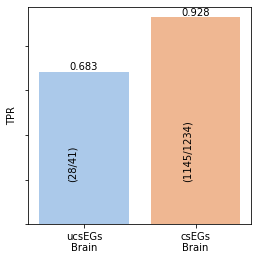

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
labels = []
data = []
tpr = []
genes = {}
#!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/ucsEG_{tissue}.txt
ucsEGs = pd.read_csv(f"ucsEG_{tissue}.txt", index_col=0, header=None).index.values
#!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/csEGs_{tissue}_EvsNE.csv
#predictions = pd.read_csv(f"csEGs_{tissue}_EvsNE.csv", index_col=0)
indices = np.intersect1d(ucsEGs, predictions.index.values)
preds = predictions.loc[indices]
num1 = len(preds[preds['label'] == preds['prediction']])
den1 = len(preds[preds['label'] == 0])
den2 = len(predictions[predictions['label'] == 0])
num2 = len(predictions[(predictions['label'] == 0) & (predictions['label'] == predictions['prediction'])])
labels += [f"ucsEGs\n{tissue}", f"csEGs\n{tissue}"]
data += [float(f"{num1 /den1:.3f}"), float(f"{num2 /den2:.3f}")]
tpr += [f"{num1}/{den1}", f"{num2}/{den2}"]
genes[f'ucsEGs_{tissue}_y'] = preds[preds['label'] == preds['prediction']].index.values
genes[f'ucsEGs_{tissue}_n'] = preds[preds['label'] != preds['prediction']].index.values
genes[f'csEGs_{tissue}_y'] = predictions[(predictions['label'] == 0) & (predictions['label'] == predictions['prediction'])].index.values
genes[f'csEGs_{tissue}_n'] = predictions[(predictions['label'] == 0) & (predictions['label'] != predictions['prediction'])].index.values
print(f"ucsEG {tissue} TPR = {num1 /den1:.3f} ({num1}/{den1}) ucsEG {tissue} TPR =  {num2/den2:.3f} ({num2}/{den2})")

f, ax = plt.subplots(figsize=(4, 4))
palette = sns.color_palette("pastel", n_colors=2)
sns.barplot(y = data, x = labels, ax=ax, hue= data, palette = palette, orient='v', legend=False)
ax.set_ylabel('TPR')
ax.set(yticklabels=[])
for i,l,t in zip(range(4),labels,tpr):
    ax.text(-0.15 + (i * 1.03), 0.2, f"({t})", rotation='vertical')
for i in ax.containers:
    ax.bar_label(i,)

This code can be used to produce Fig 5(B) of the HELP paper by executing an iteration cycle for both `kidney` and `lung` tissues.

At the end, we print the list of ucs_EGs for the tissue.

In [15]:
genes[f'ucsEGs_{tissue}_y']

array(['ACTB', 'CDK2', 'CDK6', 'CHMP7', 'CKS1B', 'DDX11', 'EMC3',
       'EXOSC1', 'FAM50A', 'FDXR', 'NCAPH2', 'NUP54', 'RBM48', 'RPL39',
       'SERBP1', 'SNRPB2', 'SRSF10', 'SSB', 'TAF1D', 'TIMM9', 'TOMM20',
       'URM1', 'USP10', 'VRK1'], dtype=object)

In [16]:
for voter in clf.estimators_:
    print(getattr(voter, "feature_importances_"))

[213  64 143 131  55 252 159  46  64  58 208  42 177 116  82 260  49   0
   0   2   0   0   0   0   0   0  52  63 117  23  63  56  65  26  39  64
  29  33  76  38  56  91  52  26  45  43  67  54  36  14  59  64  39  29
  56  83  48  30  28  33  17  19  62  21  48  37  45  39  24  38  21  58
  22  27  39  23  61  88   7  37  50  39  35  41  21  12  48  33  12  51
  23   7  38  18  28   7  56  17  51  31  29  20  22  35  15  10  29  37
  10  36  22  11  11  45  57  26  61  23  42  18  24  26  25  47  38  65
   3  19   8  17]
[251  78 120 136  79 224 169  52  97  58 239  61 162 119  46 245  30   0
   3   2   4   0   0   0   0   0  31  56  99  38  68  70  64  42  72  52
  47  59  76  47  23  92  66  44  29  35  80  84  53   9  68  63  29  36
  23  41  29  19  28  26  21  20  82  27  70  51  20  26  16  24   8  45
  31  21  15  23  38  68  11  42  38  25  26  54  33  12  45  14  16  44
  26  22  17   9  21  13  41  19  68  27  51  35  58  36   9  15  27  44
   7  34  16  22  10  33  52  32 

In [17]:
clf.fit(df_X, df_y)
getattr(clf, "feature_importances_")

array([194.53846154,  68.76923077, 126.92307692, 149.84615385,
        63.15384615, 240.30769231, 166.76923077,  51.46153846,
        83.53846154,  60.53846154, 236.92307692,  55.46153846,
       180.69230769, 139.53846154,  69.        , 261.23076923,
        34.61538462,   0.        ,   0.53846154,   4.84615385,
         1.46153846,   0.        ,   0.        ,   1.46153846,
         0.        ,   0.        ,  50.53846154,  64.84615385,
        94.07692308,  32.84615385,  55.76923077,  59.38461538,
        76.23076923,  29.61538462,  42.61538462,  49.84615385,
        35.53846154,  47.84615385,  75.30769231,  38.69230769,
        43.92307692,  92.30769231,  54.92307692,  30.61538462,
        44.61538462,  35.38461538,  68.69230769,  56.38461538,
        53.76923077,   7.69230769,  55.46153846,  72.38461538,
        37.23076923,  32.53846154,  34.15384615,  68.46153846,
        34.84615385,  23.15384615,  35.84615385,  24.30769231,
        24.92307692,  24.38461538,  55.46153846,  26.76

<ipython-input-26-f49d7329cd98>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


<Figure size 432x288 with 0 Axes>

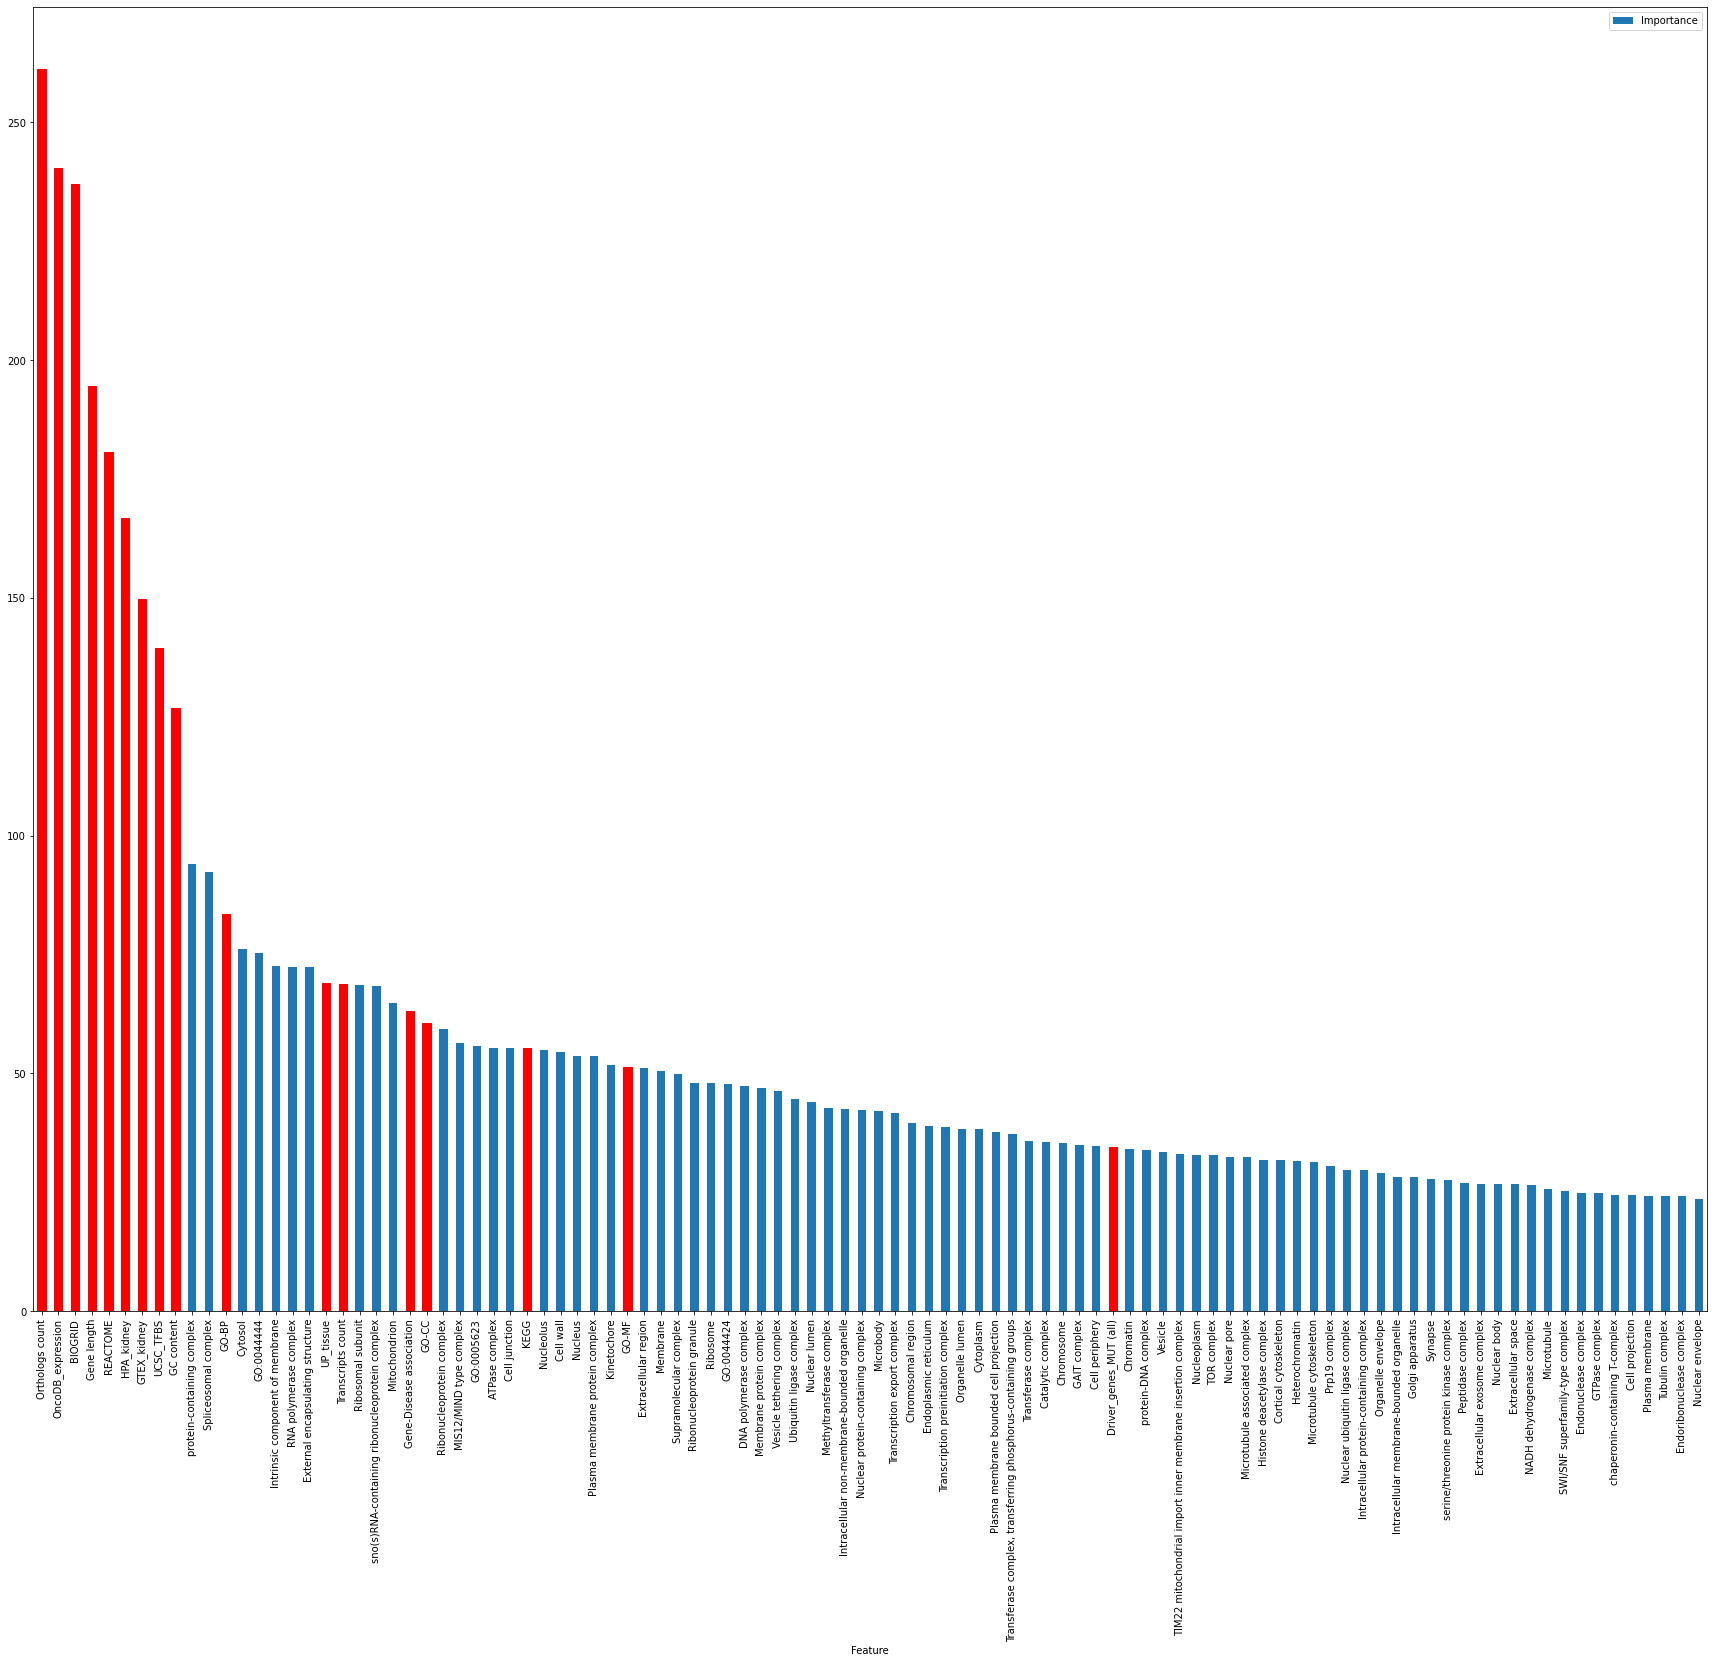

In [26]:
import matplotlib.pyplot as plt
import os
path = '.'
plt.tight_layout()
ax = pd.DataFrame({'Feature': df_X.columns, 'Importance' : 
                   clf.feature_importances_}).sort_values('Importance', ascending=False).head(100).plot.bar(x='Feature', fontsize=10, y='Importance')
fig = ax.get_figure()
fig.tight_layout()
bioattrs = pd.read_csv(os.path.join(path, 'Kidney_BIO.csv'), index_col=0).columns
for tick, feat in zip(ax.get_children(),ax.get_xticklabels()):
    if feat.get_text() in bioattrs:
        tick.set_color('r')
fig.set_size_inches(30, 24)